# Vodafone Challenge Clustering Notebook

This notebook is intended to be a general code that can be applied to any dataframe df passed as input into
the following functions. We wrote this using the dataframe we have as test input, but the code below wants
to be the more generic possible to do imputation on an incomplete dataset and then some clustering.


## Code

In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import VodafoneChallenge_Classes as VCC
import graphviz
import time

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

In [16]:
df_backup = pd.read_csv('dataset_challenge_v5.TRAINING.csv')
df_clean = df_backup.copy()

### Cleaning

The first part of this code is for the cleaning. This is the most specific part since it involves the cleaning 
suited for some specific columns, but still this can be applied for example to a dataframe of the same type of the 
one we have, just with more datapoints than the 2000 we have. 
Some instructions rely on external datasets, for example while retrieving rural info.

In [17]:
del df_clean['Unnamed: 0']

c = list(df_clean.columns)
c[0] = 'ID'
df_clean.columns = c

df_clean['ZipCode'] = df_clean['ZipCode'].map(lambda x: '%05i' % x, na_action='ignore')

traffic_columns = ['File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications']
df_clean[traffic_columns]

cats = df_clean['CustomerAge'].astype('category').cat.categories
d = {cat:(15+10*i)/100 for i,cat in enumerate(cats)}
df_clean['NumericAge'] = df_clean['CustomerAge'].map(lambda x: d[x], na_action='ignore')

d = {}
for elem in df_clean['DeviceOperatingSystem']:
    d[elem] = d.get(elem, 0) + 1
#print(d) some categories have very few values, group them
OS_other = []
for key in d:
    if d[key] < 10:
        OS_other.append(key)
        d[key] = 'other'
    else:
        d[key] = key
df_clean['OS_clean'] = df_clean['DeviceOperatingSystem'].map(lambda x: d[x], na_action='ignore')

#Adding rural/urban information
df_zip_istat = pd.read_csv('databases/database.csv')
df_istat_urb = pd.read_csv('databases/it_postal_codes.csv/Foglio 2-Tabella 1.csv', error_bad_lines=False, sep = ';')
my_urb_dict = {'Basso' : 0, 'Medio' : 1, 'Elevato' : 2}
df_istat_urb['GradoUrbaniz'] = df_istat_urb['GradoUrbaniz'].map(lambda x: my_urb_dict[x], na_action = 'ignore')

#check there are no datapoint for which we don't have zip but we've region
df_clean['ZipCode'].isnull()
df_clean['Region'][df_clean['ZipCode'].isnull()]
len(df_clean['Region'][df_clean['ZipCode'].isnull()]) == np.sum(df_clean['Region'][df_clean['ZipCode'].isnull()].isnull())

#we need to insert x for multiple cap cities
isnan = lambda x: x != x
#nan is unique type not equal to itself, so with this lambda function we get True only when the type is NaN

for i in range(df_zip_istat.shape[0]):
    cap = df_zip_istat.loc[i, 'cap/0']
    cap  = '%05d' % cap
    if not isnan(df_zip_istat.loc[i,'cap/1']):
        if not isnan(df_zip_istat.loc[i,'cap/10']):   
            cap = cap[:-2]+'xx'
        else:
            cap = cap[:-1]+'x'
    df_zip_istat.loc[i, 'cap/0'] = cap

d_zip_istat = df_zip_istat.set_index('cap/0').to_dict()['codice']
d_istat_urb = df_istat_urb.set_index('ISTAT').to_dict()['GradoUrbaniz']

mask = df_clean['ZipCode'].isnull()
urban_col = np.zeros(df_clean.shape[0])
urban_col_masked = urban_col[~ mask]
d_zip_istat.update([('51021', 47023),( '83026', 64121),( '74025', 73007),( '55062', 46007),( '38039', 22217),('50037', 48053)])
d_istat_urb.update([(22250, 0),( 78157, 1)])

c = 0
for i in df_clean['ZipCode'][~ mask]:
    try:
        temp = d_zip_istat[i]
        urban_col_masked[c] = d_istat_urb[int(temp)]
    except KeyError:
        i = '%05d' % int(i)
        if i[:-1]+'x' in d_zip_istat:
            temp = d_zip_istat[i[:-1]+'x']
        elif i[:-2]+'xx' in d_zip_istat:
            temp = d_zip_istat[i[:-2]+'xx']
        else:
            raise()
    c += 1
    
df_clean['Urban'] = df_clean['ZipCode'].copy()
df_clean['Urban'][~ mask] = urban_col_masked

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Imputation

The second part of this code is for imputation of missing values. On our notebook we used the function test_sup to find which supervised learning algorithm best performed the prediction. Here we base our imputation on those findings and therefore we avoid to run the test_sup function several times. 
The algorithms analyzed by test_sup were perceptron, MLP, logistic regression and trees (decision tree, random forest, extreme random forest) and in the end we found out that MLP and XRF are the ones that usually gave us the best
prediction scores.

tscore=0.910359 vscore=0.917051
Score on smaller part (41.47%) of validation set (unbalanced case): 0.82
Score on bigger part (58.53%) of validation set (unbalanced case): 0.98
Category histogram in validation set: {'iOS': 87, 'Android': 127, 'other': 3}


/Users/Renato/Desktop/ML-Challenge/VodafoneChallenge_Classes.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=1.1345175113491226 tscore=0.37011294526498695 vscore=0.344
epoch=1 loss=1.125695487727928 tscore=0.4326672458731538 vscore=0.38
epoch=2 loss=1.1186360027892326 tscore=0.4483058210251955 vscore=0.376
epoch=3 loss=1.1125523537088673 tscore=0.4465682015638575 vscore=0.384
epoch=4 loss=1.1086529155545581 tscore=0.4448305821025195 vscore=0.392
epoch=5 loss=1.1049751483180048 tscore=0.4456993918331885 vscore=0.4
epoch=6 loss=1.1023137967304582 tscore=0.4456993918331885 vscore=0.396
epoch=7 loss=1.1005657406764182 tscore=0.4456993918331885 vscore=0.396
epoch=8 loss=1.098597295901606 tscore=0.4456993918331885 vscore=0.396
epoch=9 loss=1.0965630002907927 tscore=0.4448305821025195 vscore=0.396
epoch=10 loss=1.0944820636110983 tscore=0.4448305821025195 vscore=0.396
epoch=11 loss=1.0929720342003975 tscore=0.4456993918331885 vscore=0.396
epoch=12 loss=1.0915606503807638 tscore=0.4456993918331885 vscore=0.396
epoch=13 loss=1.090955604457659 tscore=0.4456993918331885 vscore=0.396
epoch=1

/Users/Renato/Desktop/ML-Challenge/VodafoneChallenge_Classes.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction


run=1 tscore=0.644106 vscore=0.65493
run=2 tscore=0.639544 vscore=0.651408
run=3 tscore=0.634981 vscore=0.661972
run=4 tscore=0.615209 vscore=0.647887
run=5 tscore=0.609886 vscore=0.644366
run=6 tscore=0.596198 vscore=0.637324
run=7 tscore=0.590875 vscore=0.637324
run=8 tscore=0.580228 vscore=0.633803
run=9 tscore=0.579468 vscore=0.644366
run=10 tscore=0.578707 vscore=0.647887
run=11 tscore=0.581749 vscore=0.640845
run=12 tscore=0.578707 vscore=0.633803
run=13 tscore=0.574905 vscore=0.626761
run=14 tscore=0.575665 vscore=0.623239
run=15 tscore=0.578707 vscore=0.626761
run=16 tscore=0.580228 vscore=0.630282
run=17 tscore=0.579468 vscore=0.623239
run=18 tscore=0.578707 vscore=0.619718
run=19 tscore=0.574905 vscore=0.623239
run=20 tscore=0.573384 vscore=0.623239
run=21 tscore=0.572624 vscore=0.612676
run=22 tscore=0.570342 vscore=0.612676
run=23 tscore=0.569582 vscore=0.609155
run=24 tscore=0.569582 vscore=0.605634
run=25 tscore=0.568821 vscore=0.605634
run=26 tscore=0.570342 vscore=0.605

/Users/Renato/Desktop/ML-Challenge/VodafoneChallenge_Classes.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=7 loss=1.7073886337272508 tscore=0.37101185050136737 vscore=0.3771186440677966
epoch=8 loss=1.6976439875707356 tscore=0.37101185050136737 vscore=0.3771186440677966
epoch=9 loss=1.6884189179093183 tscore=0.37101185050136737 vscore=0.3771186440677966
epoch=10 loss=1.6797534799567155 tscore=0.37101185050136737 vscore=0.3771186440677966
epoch=11 loss=1.6718661322603503 tscore=0.37101185050136737 vscore=0.3771186440677966
epoch=12 loss=1.664223473757845 tscore=0.37101185050136737 vscore=0.3771186440677966
epoch=13 loss=1.6575593607688772 tscore=0.37101185050136737 vscore=0.3771186440677966
epoch=14 loss=1.6512760523045307 tscore=0.37101185050136737 vscore=0.3771186440677966
epoch=15 loss=1.645190623115241 tscore=0.37101185050136737 vscore=0.3771186440677966
epoch=16 loss=1.6400429610755982 tscore=0.37101185050136737 vscore=0.3771186440677966
epoch=17 loss=1.6354931302295592 tscore=0.37101185050136737 vscore=0.3771186440677966
epoch=18 loss=1.6308666556473577 tscore=0.37101185050136737

/Users/Renato/Desktop/ML-Challenge/VodafoneChallenge_Classes.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction


tscore=0.679583 vscore=0.596491
Score on smaller part (41.40%) of validation set (unbalanced case): 0.07
Score on bigger part (58.60%) of validation set (unbalanced case): 0.97
Category histogram in validation set: {'0.2': 21, '0.0': 167, '0.1': 92, '0.4': 2, '0.3': 3}
epoch=0 loss=2.2974011808864168 tscore=0.033816425120772944 vscore=0.02242152466367713


/Users/Renato/Desktop/ML-Challenge/VodafoneChallenge_Classes.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=1 loss=2.271328514592009 tscore=0.07246376811594203 vscore=0.06726457399103139
epoch=2 loss=2.2467104128948447 tscore=0.14879227053140096 vscore=0.10762331838565023
epoch=3 loss=2.2231264623757205 tscore=0.2106280193236715 vscore=0.17937219730941703
epoch=4 loss=2.1999016495969768 tscore=0.3033816425120773 vscore=0.26905829596412556
epoch=5 loss=2.1777216073515593 tscore=0.33816425120772947 vscore=0.3004484304932735
epoch=6 loss=2.156386961619353 tscore=0.34202898550724636 vscore=0.3004484304932735
epoch=7 loss=2.134606117728429 tscore=0.34202898550724636 vscore=0.30493273542600896
epoch=8 loss=2.111889117944555 tscore=0.34202898550724636 vscore=0.30493273542600896
epoch=9 loss=2.088715016830338 tscore=0.34202898550724636 vscore=0.30493273542600896
epoch=10 loss=2.065181954008073 tscore=0.34202898550724636 vscore=0.30493273542600896
epoch=11 loss=2.0417600872820105 tscore=0.34202898550724636 vscore=0.30493273542600896
epoch=12 loss=2.0177034263365274 tscore=0.34202898550724636 vs

/Users/Renato/Desktop/ML-Challenge/VodafoneChallenge_Classes.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction


run=1 tscore=0.436662 vscore=0.477193
run=2 tscore=0.436662 vscore=0.477193
run=3 tscore=0.436662 vscore=0.477193
run=4 tscore=0.436662 vscore=0.477193
run=5 tscore=0.436662 vscore=0.477193
run=6 tscore=0.436662 vscore=0.477193
run=7 tscore=0.436662 vscore=0.477193
run=8 tscore=0.441878 vscore=0.480702
run=9 tscore=0.448584 vscore=0.480702
run=10 tscore=0.45231 vscore=0.487719
run=11 tscore=0.453055 vscore=0.491228
run=12 tscore=0.458271 vscore=0.491228
run=13 tscore=0.464978 vscore=0.491228
run=14 tscore=0.466468 vscore=0.484211
run=15 tscore=0.468703 vscore=0.480702
run=16 tscore=0.472429 vscore=0.491228
run=17 tscore=0.472429 vscore=0.494737
run=18 tscore=0.47392 vscore=0.494737
run=19 tscore=0.474665 vscore=0.494737
run=20 tscore=0.473174 vscore=0.501754
run=21 tscore=0.47541 vscore=0.498246
run=22 tscore=0.476155 vscore=0.494737
run=23 tscore=0.47541 vscore=0.494737
run=24 tscore=0.47541 vscore=0.494737
run=25 tscore=0.47392 vscore=0.487719
run=26 tscore=0.474665 vscore=0.487719
r

/Users/Renato/Desktop/ML-Challenge/VodafoneChallenge_Classes.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction
/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


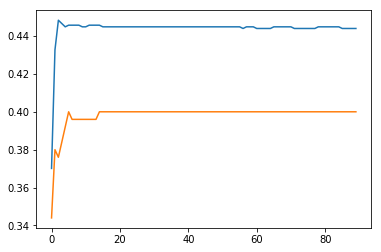

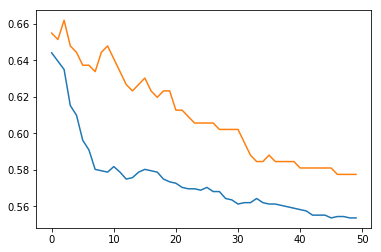

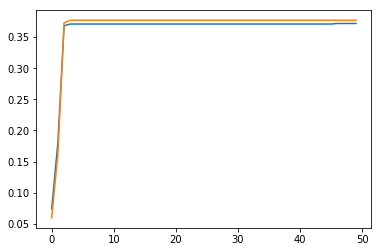

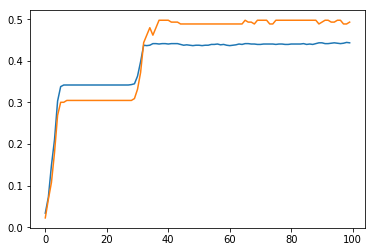

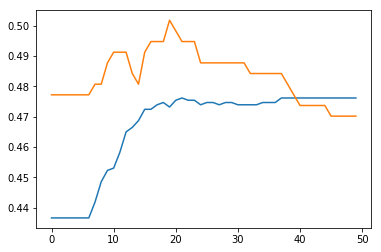

In [18]:
df_filled = df_clean.copy()
build_seed = 456245


#imputation for operating system, done with XRF
percentage_used = (0.70,0.15,0.15)
X = df_filled[traffic_columns]
y = df_filled['OS_clean']

my_forest = VCC.trees(build_seed)
my_forest.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)
os_missing = my_forest.predict(X,y, fill_up=True)

#imputation for urbanization, done with MLP
X = df_filled[traffic_columns]
df_filled['Urban'] = df_filled['Urban'].map(lambda x: int(x), na_action = 'ignore')
y = df_filled['Urban']

my_MLP = VCC.MLP(build_seed)
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=90,
             hidden_layer_sizes = (200,), batch_size = 50, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.10, tol = 1e-4)
urbanization = my_MLP.predict(X,y, fill_up=True)

#imputation for Numeric Age, done with Perceptron
dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
df_filled["NumericAge"] = df_filled["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df_filled[traffic_columns]
y = df_filled['NumericAge']


my_perc = VCC.perc(build_seed)
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', 
              eta0=1e-4, class_weight={2.0: 261.4, 1.0: 1.54, 0.0: 4.20})
num_age = my_perc.predict(X,y, fill_up=True)

#imputation for data allowance, done with MLP over a masked dataset of points below 0.5 (since looking at the
#density we noticed that there are just few outliers above 0.5)
mask = df_clean['DataAllowance'] > 0.5
X = df_filled[traffic_columns][~mask]
df_filled['DataAllowance'] = df_filled['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['DataAllowance'][~mask]

my_MLP = VCC.MLP(build_seed)
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,
             hidden_layer_sizes = (400,), batch_size = 100, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.05, tol = 1e-4)
#to predict we go back to our entire column
X = df_filled[traffic_columns]
y = df_filled['DataAllowance']
data_all = my_MLP.predict(X,y, fill_up=True)

#imputation for Monthly Data Traffic, done with XRF
X = df_filled[traffic_columns]
df_filled['MonthlyDataTraffic'] = df_filled['MonthlyDataTraffic'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['MonthlyDataTraffic']

my_forest = VCC.trees(build_seed)
my_forest.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)
data_traffic = my_forest.predict(X,y, fill_up=True)

#imputation for data ARPU, done with MLP
X = df_filled[traffic_columns]
df_filled['DataArpu'] = df_filled['DataArpu'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['DataArpu']

my_MLP = VCC.MLP(build_seed)
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
             hidden_layer_sizes = (200,50), batch_size = 100, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)
data_arpu = my_MLP.predict(X,y, fill_up=True)

#imputation for Monthly Voice TrafficCount, done with Perceptron
X = df_filled[traffic_columns]
df_filled['MonthlyVoiceTrafficCount'] = df_filled['MonthlyVoiceTrafficCount'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['MonthlyVoiceTrafficCount']

my_perc = VCC.perc(build_seed)
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-6, power_t=0.7, it_interval=100, learning_rate='constant', 
              eta0=1e-4, class_weight=None)
voice_traffic_c = my_perc.predict(X,y, fill_up=True)


#Once imputation is finished, we build our completed dataset df_good and we print some info. 
#We also have to add to MonthlySMSTrafficCount one unique value (we've a single nan). We choose to do that
#very simply with the mean.
df_good = df_filled.copy()
col_to_del = ['CustomerAge', 'DevicePrice', 'Province', 'Region', 'ZipCode', 'DeviceOperatingSystem']
df_good.drop(col_to_del, axis=1, inplace=True)
df_good['MonthlySmsTrafficCount'][df_good['MonthlySmsTrafficCount'].isnull()] = df_good['MonthlySmsTrafficCount'].mean()
df_good.info()

### Preparing dataset for Clustering

The third part of this code is for preparing the dataset for clustering, by transforming word categories to numbers and performing one-hot encoding. We then initialize the array optimal_weights which represent the weights we use for clustering, found by a greedy grid search algorithm (see other notebook).

In [23]:
df = df_good.copy()
col = df.columns[2:]

d_map = {'iOS': 1, 'Android': 2, 'other': 3}
df['OS_clean'] = df['OS_clean'].map(d_map, na_action='ignore')
cat_map = {'V-Bag': 1, 'V-Auto': 2, 'V-Pet': 3, 'V-Camera': 4}
df['Product'] = df['Product'].map(cat_map, na_action='ignore')

cat_col = [i for i in col if i not in traffic_columns]
non_cat_col = [i for i in col if i not in cat_col]
cat_col.pop(cat_col.index('MonthlySmsTrafficCount'))

X = df[col]
y = df['Product']
data = VCC.buildTrain(X, y,  perc=(0.7,0.15,0.15), std=False, pca=0, seed=None, one_hot=True, cat_col=cat_col)

knn1 = KNeighborsClassifier(n_neighbors=4)

optimal_weights = np.array([0, 0, 0, 0.86956522, 0, 7.53623188, 0, 0, 6.08695652, 0,
        0, 2.89855072, 0.43478261, 0.43478261, 1.01449275, 1.01449275, 1.01449275, 1.01449275, 1.01449275, 1.88405797,
        0, 1.88405797, 0.28985507, 0, 0, 2.02898551, 0.72463768, 1.01449275, 0.14492754, 1.88405797,
        0, 0, 0, 0, 0, 1.15942029, 1.01449275, 0.28985507, 1.01449275, 1.01449275,
        1.01449275, 1.15942029, 1.01449275, 0, 0, 0, 0, 0, 1.01449275, 1.01449275,
        2.17391304, 0.43478261, 0.86956522, 0.86956522, 0, 0.57971014, 0, 1.30434783, 1.01449275, 2.17391304, 0, 0.72463768, 
        1.01449275, 2.17391304, 1.01449275, 1.01449275, 0, 0.86956522, 1.01449275, 1.01449275])

mask = optimal_weights>0

### Clustering

The final part of this code is the actual clustering part. Here we put only the best performing clustering algorithm, found through the v_measure score, as can be seen in the other notebook. We decided to put an unsupervised clustering algorithm, hierarchical clustering with 8 neighbours, and also a supervised MLP for classification (we compared it to a random forest and it obtained higher score), with implemented the possibility of predicting probabilities of belonging to each class, thanks to the predict_proba method.

##### Hierarchical Clustering


 ****** Hierarchical Clustering: 8 ******

cluster: 0
--> top category: 1, frequency of category (variety within cluster): 40.00%, category clustering: 8.55%
Cluster size: 8.39%
--> histogram: {2: 24.0, 3: 36.0, 4: 0.0, 1: 40.0}

cluster: 1
--> top category: 1, frequency of category (variety within cluster): 44.44%, category clustering: 17.09%
Cluster size: 15.10%
--> histogram: {2: 8.88888888888889, 3: 42.22222222222222, 4: 4.444444444444445, 1: 44.44444444444444}

cluster: 2
--> top category: 1, frequency of category (variety within cluster): 38.33%, category clustering: 19.66%
Cluster size: 20.13%
--> histogram: {2: 25.0, 3: 28.333333333333332, 4: 8.333333333333332, 1: 38.333333333333336}

cluster: 3
--> top category: 1, frequency of category (variety within cluster): 35.14%, category clustering: 11.11%
Cluster size: 12.42%
--> histogram: {2: 27.027027027027028, 3: 29.72972972972973, 4: 8.108108108108109, 1: 35.13513513513514}

cluster: 4
--> top category: 1, frequency of category 

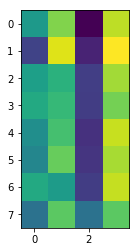

In [25]:
print('\n ****** Hierarchical Clustering: 8 ******' )
hc = AgglomerativeClustering(n_clusters=8, affinity='euclidean',linkage='ward')
hc.fit(*data.get_test())
VCC.check_clusters(y=data.get_test()[1], clust_labels=hc.labels_, v=True)
score_hc = metrics.v_measure_score(data.get_test()[1], hc.labels_)

##### Multi Layer Perceptron

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=4.131441170910563 tscore=0.27805222300635146 vscore=0.256140350877193
epoch=1 loss=4.109325752085456 tscore=0.28793225123500354 vscore=0.26666666666666666
epoch=2 loss=4.088796842874049 tscore=0.29357798165137616 vscore=0.2771929824561403
epoch=3 loss=4.068381982966561 tscore=0.2992237120677488 vscore=0.2912280701754386
epoch=4 loss=4.048711553548369 tscore=0.3112208892025406 vscore=0.3017543859649123
epoch=5 loss=4.029543319907989 tscore=0.32180663373323926 vscore=0.3157894736842105
epoch=6 loss=4.010429357823475 tscore=0.32815808045165845 vscore=0.32280701754385965
epoch=7 loss=3.992083343436501 tscore=0.32886379675370503 vscore=0.3263157894736842
epoch=8 loss=3.9740659987681384 tscore=0.33380381086803107 vscore=0.3368421052631579
epoch=9 loss=3.956660005244955 tscore=0.3295695130557516 vscore=0.3473684210526316
epoch=10 loss=3.939192920557067 tscore=0.3330980945659845 vscore=0.3473684210526316
epoch=11 loss=3.9223965078222 tscore=0.3359209597741708 vscore=0.347368421052

epoch=97 loss=2.9662838047855673 tscore=0.40014114326040934 vscore=0.3473684210526316
epoch=98 loss=2.957641316734731 tscore=0.4008468595624559 vscore=0.3473684210526316
epoch=99 loss=2.9490789776555864 tscore=0.4008468595624559 vscore=0.3473684210526316
epoch=100 loss=2.940567455017593 tscore=0.40296400846859565 vscore=0.3473684210526316
epoch=101 loss=2.9320163220297712 tscore=0.40225829216654907 vscore=0.3473684210526316
epoch=102 loss=2.9235101459398747 tscore=0.40296400846859565 vscore=0.3473684210526316
epoch=103 loss=2.9150557806483066 tscore=0.4036697247706422 vscore=0.3473684210526316
epoch=104 loss=2.9066522611547096 tscore=0.4036697247706422 vscore=0.3473684210526316
epoch=105 loss=2.898273392402385 tscore=0.4036697247706422 vscore=0.3473684210526316
epoch=106 loss=2.889965143933427 tscore=0.4036697247706422 vscore=0.3473684210526316
epoch=107 loss=2.88164100083108 tscore=0.4036697247706422 vscore=0.3473684210526316
epoch=108 loss=2.873401189256214 tscore=0.4050811573747354 

epoch=194 loss=2.2929785496899306 tscore=0.41284403669724773 vscore=0.34385964912280703
epoch=195 loss=2.2875293460074464 tscore=0.41284403669724773 vscore=0.34385964912280703
epoch=196 loss=2.282136097589562 tscore=0.4135497529992943 vscore=0.34385964912280703
epoch=197 loss=2.2767441726424735 tscore=0.41284403669724773 vscore=0.34385964912280703
epoch=198 loss=2.271372971822793 tscore=0.41284403669724773 vscore=0.3473684210526316
epoch=199 loss=2.2660383204712566 tscore=0.4135497529992943 vscore=0.3508771929824561
epoch=200 loss=2.2607182916400137 tscore=0.4114326040931546 vscore=0.3508771929824561
epoch=201 loss=2.2554389138737445 tscore=0.4114326040931546 vscore=0.3543859649122807
epoch=202 loss=2.2502009174143534 tscore=0.4114326040931546 vscore=0.3508771929824561
epoch=203 loss=2.244967334331152 tscore=0.40860973888496827 vscore=0.3508771929824561
epoch=204 loss=2.239805132531067 tscore=0.40860973888496827 vscore=0.3508771929824561
epoch=205 loss=2.2346355682133 tscore=0.40860973

epoch=294 loss=1.8641671829811506 tscore=0.41213832039520115 vscore=0.3543859649122807
epoch=295 loss=1.8608713737465392 tscore=0.41284403669724773 vscore=0.3543859649122807
epoch=296 loss=1.8575956318929383 tscore=0.41213832039520115 vscore=0.36140350877192984
epoch=297 loss=1.8543358598672526 tscore=0.41284403669724773 vscore=0.35789473684210527
epoch=298 loss=1.8510796640778475 tscore=0.41213832039520115 vscore=0.36140350877192984
epoch=299 loss=1.847865425302559 tscore=0.41213832039520115 vscore=0.36140350877192984


array([[0.34772992, 0.28402829, 0.25169627, 0.11654552],
       [0.30814017, 0.15424625, 0.45714714, 0.08046643],
       [0.39606177, 0.23161043, 0.28513341, 0.08719439],
       [0.36587655, 0.27069775, 0.25743212, 0.10599359],
       [0.33825548, 0.16027589, 0.43352872, 0.0679399 ],
       [0.37668792, 0.24167232, 0.29150202, 0.09013774],
       [0.37568606, 0.20117941, 0.32774916, 0.09538537],
       [0.40788641, 0.24122652, 0.264883  , 0.08600407],
       [0.36099188, 0.24444282, 0.285161  , 0.1094043 ],
       [0.35185887, 0.19250161, 0.3494938 , 0.10614571],
       [0.36771857, 0.24064872, 0.30278231, 0.0888504 ],
       [0.35814241, 0.26233123, 0.28984455, 0.08968181],
       [0.38391223, 0.21928731, 0.30711408, 0.08968638],
       [0.33428125, 0.23890755, 0.32207322, 0.10473797],
       [0.35654365, 0.1844498 , 0.37094798, 0.08805856],
       [0.36233471, 0.2406836 , 0.3095402 , 0.08744149],
       [0.36526228, 0.25455817, 0.26662197, 0.11355759],
       [0.33541376, 0.18768878,

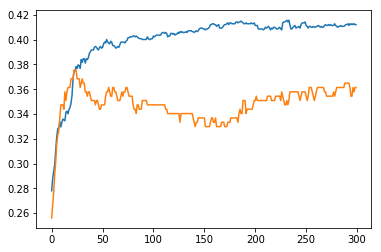

In [28]:
my_MLP = VCC.MLP(data=data)
my_MLP.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=300,
             hidden_layer_sizes = (200,50), batch_size = 600, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 13.5, tol = 1e-4)
my_MLP.obj.predict_proba(data.get_test()[0])